In [ ]:
!pip install librosa==0.10.1
!pip install numpy --upgrade --force-reinstall
!pip install -U scikit-learn
!pip install librosa
!pip install matplotlib
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 76.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━

**CNN V1**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔄 Chargement des données...
Données chargées avec X shape: (4000, 128, 130), y shape: (4000,)
🔎 Avant équilibrage : Counter({np.int64(0): 2000, np.int64(1): 2000})
✅ Après équilibrage : Counter({np.int64(0): 2000, np.int64(1): 2000})
📀 Shape train: (3200, 128, 130, 1), test: (800, 128, 130, 1)
Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.8825 - loss: 0.2557 - val_accuracy: 0.6234 - val_loss: 0.6665 - learning_rate: 0.0010
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9807 - loss: 0.0535 - val_accuracy: 0.5047 - val_loss: 1.2366 - learning_rate: 0.0010
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9891 - loss: 0.0323 - val_accuracy: 0.9250 - val_loss: 0.1843 - learning_rate: 0.0010
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9790 - loss: 0.0438 - val_accuracy: 0.9734 - val

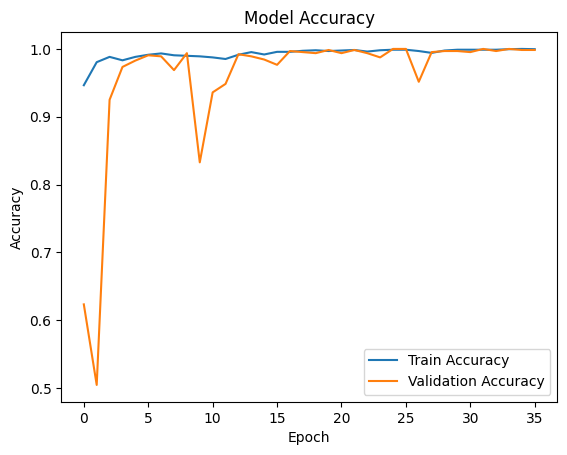

In [ ]:
# 📌 MONTAGE & IMPORTS
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# 📂 PARAMÈTRES
DATA_PATH = "/content/drive/MyDrive"
SAMPLE_RATE = 22050
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
FIXED_TIME_STEPS = 130

# 🎵 EXTRACTION MEL AVEC AUGMENTATION
def extract_features_with_augmentation(file_path, max_len=SAMPLES_PER_TRACK, fixed_time_steps=FIXED_TIME_STEPS):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(y) < max_len:
            y = np.pad(y, (0, max_len - len(y)), mode='constant')
        else:
            y = y[:max_len]

        # Augmentation : seulement bruit
        noise = y + 0.005 * np.random.randn(len(y))

        features = []
        for y_aug in [y, noise]:
            mel = librosa.feature.melspectrogram(y=y_aug, sr=sr, n_mels=128)
            mel_db = librosa.power_to_db(mel, ref=np.max).astype(np.float32)
            if mel_db.shape[1] < fixed_time_steps:
                mel_db = np.pad(mel_db, ((0, 0), (0, fixed_time_steps - mel_db.shape[1])), mode='constant')
            else:
                mel_db = mel_db[:, :fixed_time_steps]
            if not np.isnan(mel_db).any():
                features.append(mel_db)
        return features if features else None
    except Exception as e:
        print(f"Erreur lors du traitement de {file_path}: {e}")
        return None

# 📅 CHARGEMENT DATA
def load_data(fixed_time_steps=FIXED_TIME_STEPS, max_files_per_class=None):
    X, y = [], []
    label_map = {'non_belle_voix': 0, 'belle_voix': 1}
    for label_name, label in label_map.items():
        folder = os.path.join(DATA_PATH, label_name)
        file_count = 0
        for fname in os.listdir(folder):
            if fname.endswith(".wav"):
                if max_files_per_class is not None and file_count >= max_files_per_class:
                    break
                fpath = os.path.join(folder, fname)
                feats = extract_features_with_augmentation(fpath, fixed_time_steps=fixed_time_steps)
                if feats:
                    for feat in feats:
                        if feat.shape == (128, fixed_time_steps):
                            X.append(feat)
                            y.append(label)
                        else:
                            print(f"Ignore {fpath}: forme inattendue {feat.shape}")
                    file_count += 1
    X = np.array(X, dtype=np.float32)
    y = np.array(y)
    print(f"Données chargées avec X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# ⚖️ ÉQUILIBRAGE
def balance(X, y):
    X_flat = X.reshape((X.shape[0], -1))
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X_flat, y)
    X_res = X_res.reshape((-1, X.shape[1], X.shape[2])).astype(np.float32)
    return X_res, y_res

# 🧼 PRÉTRAITEMENT
def preprocess(X, y):
    for i in range(X.shape[0]):
        X[i] = (X[i] - X[i].min()) / (X[i].max() - X[i].min() + 1e-8)
    X = X[..., np.newaxis]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    return X_train, X_test, y_train, y_test, dict(enumerate(class_weights))

# 🧐 CNN AMÉLIORÉ
def build_advanced_cnn(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.TimeDistributed(layers.Flatten()),
        layers.GRU(128, return_sequences=False),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# 🚀 PIPELINE COMPLET
print("🔄 Chargement des données...")
X, y = load_data(fixed_time_steps=FIXED_TIME_STEPS, max_files_per_class=1000)  # Limite à 1000 fichiers par classe
print(f"🔎 Avant équilibrage : {Counter(y)}")
X, y = balance(X, y)
print(f"✅ Après équilibrage : {Counter(y)}")
X_train, X_test, y_train, y_test, class_weights = preprocess(X, y)
print(f"📀 Shape train: {X_train.shape}, test: {X_test.shape}")

# 🎯 ENTRAÎNEMENT
model = build_advanced_cnn(X_train.shape[1:])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,  # Réduit pour moins de mémoire
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler],
    shuffle=True
)

# 📊 ÉVALUATION
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"🎯 Test accuracy : {test_acc:.4f}")

# 📈 VISUALISATION
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**CNN V2**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔄 Chargement des données...
Données chargées avec X shape: (4000, 128, 130), y shape: (4000,)
🔎 Avant équilibrage : Counter({np.int64(0): 2000, np.int64(1): 2000})
✅ Après équilibrage : Counter({np.int64(0): 2000, np.int64(1): 2000})
📀 Shape train: (3200, 128, 130, 1), test: (800, 128, 130, 1)
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.9091 - auc: 0.9524 - loss: 1.6648 - precision: 0.9008 - recall: 0.9215 - val_accuracy: 0.6021 - val_auc: 0.6886 - val_loss: 1.4083 - val_precision: 0.5626 - val_recall: 0.9836 - learning_rate: 5.0000e-04
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9905 - auc: 0.9997 - loss: 0.6227 - precision: 0.9919 - recall: 0.9895 - val_accuracy: 0.5094 - val_auc: 0.9666 - val_loss: 1.2207 - val_precision: 0.5094 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 3/50
140/140 ━━━━━━━━━━━━━

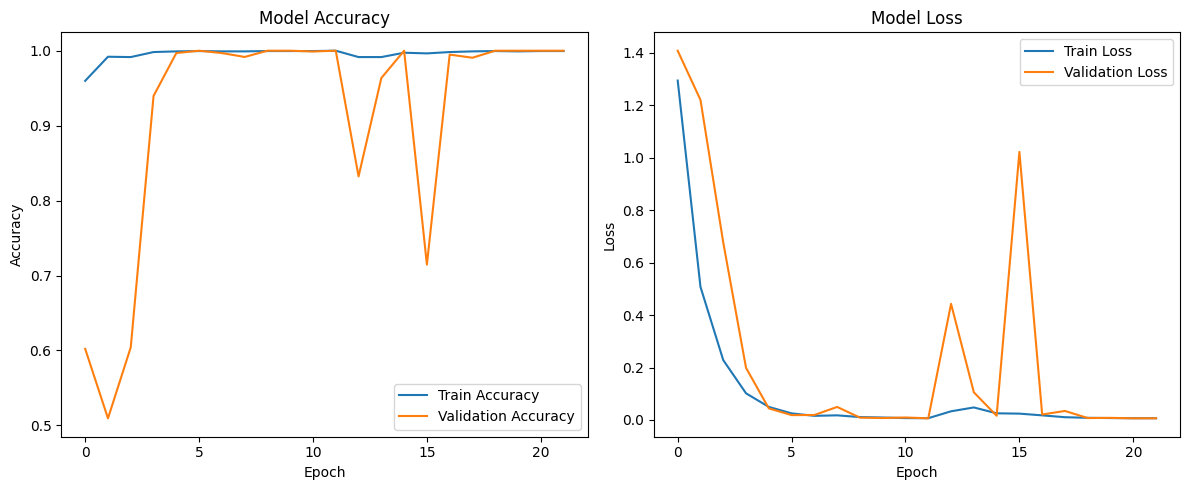

In [2]:
# 📌 MONTAGE & IMPORTS
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# 📂 PARAMÈTRES
DATA_PATH = "/content/drive/MyDrive"
SAMPLE_RATE = 22050
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
FIXED_TIME_STEPS = 130

# 🎵 EXTRACTION MEL AVEC AUGMENTATION
def extract_features_with_augmentation(file_path, max_len=SAMPLES_PER_TRACK, fixed_time_steps=FIXED_TIME_STEPS):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(y) < max_len:
            y = np.pad(y, (0, max_len - len(y)), mode='constant')
        else:
            y = y[:max_len]

        # Augmentation : seulement bruit (réduit pour limiter la RAM)
        noise = y + 0.005 * np.random.randn(len(y))

        features = []
        for y_aug in [y, noise]:
            mel = librosa.feature.melspectrogram(y=y_aug, sr=sr, n_mels=128)
            mel_db = librosa.power_to_db(mel, ref=np.max).astype(np.float32)
            if mel_db.shape[1] < fixed_time_steps:
                mel_db = np.pad(mel_db, ((0, 0), (0, fixed_time_steps - mel_db.shape[1])), mode='constant')
            else:
                mel_db = mel_db[:, :fixed_time_steps]
            if not np.isnan(mel_db).any():
                features.append(mel_db)
        return features if features else None
    except Exception as e:
        print(f"Erreur lors du traitement de {file_path}: {e}")
        return None

# 📅 CHARGEMENT DATA
def load_data(fixed_time_steps=FIXED_TIME_STEPS, max_files_per_class=None):
    X, y = [], []
    label_map = {'non_belle_voix': 0, 'belle_voix': 1}
    for label_name, label in label_map.items():
        folder = os.path.join(DATA_PATH, label_name)
        file_count = 0
        for fname in os.listdir(folder):
            if fname.endswith(".wav"):
                if max_files_per_class is not None and file_count >= max_files_per_class:
                    break
                fpath = os.path.join(folder, fname)
                feats = extract_features_with_augmentation(fpath, fixed_time_steps=fixed_time_steps)
                if feats:
                    for feat in feats:
                        if feat.shape == (128, fixed_time_steps):
                            X.append(feat)
                            y.append(label)
                        else:
                            print(f"Ignore {fpath}: forme inattendue {feat.shape}")
                    file_count += 1
    X = np.array(X, dtype=np.float32)
    y = np.array(y)
    print(f"Données chargées avec X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# ⚖️ ÉQUILIBRAGE
def balance(X, y):
    X_flat = X.reshape((X.shape[0], -1))
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X_flat, y)
    X_res = X_res.reshape((-1, X.shape[1], X.shape[2])).astype(np.float32)
    return X_res, y_res

# 🧼 PRÉTRAITEMENT
def preprocess(X, y):
    for i in range(X.shape[0]):
        X[i] = (X[i] - X[i].min()) / (X[i].max() - X[i].min() + 1e-8)
    X = X[..., np.newaxis]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    return X_train, X_test, y_train, y_test, dict(enumerate(class_weights))

# 🧐 CNN AMÉLIORÉ
def build_advanced_cnn(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.TimeDistributed(layers.Flatten()),
        layers.GRU(128, return_sequences=False),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=AdamW(learning_rate=0.0005, weight_decay=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                          tf.keras.metrics.Recall(name='recall'),
                          tf.keras.metrics.AUC(name='auc')])  # Utilisation des objets de métriques
    return model

# 🚀 PIPELINE COMPLET
print("🔄 Chargement des données...")
X, y = load_data(fixed_time_steps=FIXED_TIME_STEPS, max_files_per_class=1000)
print(f"🔎 Avant équilibrage : {Counter(y)}")
X, y = balance(X, y)
print(f"✅ Après équilibrage : {Counter(y)}")
X_train, X_test, y_train, y_test, class_weights = preprocess(X, y)
print(f"📀 Shape train: {X_train.shape}, test: {X_test.shape}")

# 🎯 ENTRAÎNEMENT
model = build_advanced_cnn(X_train.shape[1:])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=50,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler],
    shuffle=True
)

# 📊 ÉVALUATION
test_metrics = model.evaluate(X_test, y_test, return_dict=True)
print(f"🎯 Test metrics: Accuracy: {test_metrics['accuracy']:.4f}, "
      f"Precision: {test_metrics['precision']:.4f}, "
      f"Recall: {test_metrics['recall']:.4f}, "
      f"AUC: {test_metrics['auc']:.4f}")

# 🔍 ANALYSE DES ERREURS
y_pred = (model.predict(X_test) > 0.5).astype(int)
errors = np.where(y_pred.flatten() != y_test)[0]
print(f"Indices des échantillons mal classés dans l'ensemble de test : {errors}")
print(f"Nombre total d'erreurs : {len(errors)}")

# 📈 VISUALISATION
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**LSTM**

✅ Chargé : 10617 fichiers


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - accuracy: 0.6491 - loss: 0.5839 - val_accuracy: 0.6492 - val_loss: 0.4947
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.6631 - loss: 0.4899 - val_accuracy: 0.6498 - val_loss: 0.4813
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 35s 164ms/step - accuracy: 0.6680 - loss: 0.4909 - val_accuracy: 0.6557 - val_loss: 0.4829
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.6588 - loss: 0.4851 - val_accuracy: 0.6510 - val_loss: 0.4774
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.6613 - loss: 0.4775 - val_accuracy: 0.6416 - val_loss: 0.4799
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.6668 - loss: 0.4813 - val_accuracy: 0.6404 - val_loss: 0.4824
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 155ms/step - accuracy: 0.6740 - loss: 0.4726 - val_accuracy: 0.6627 - val_loss: 0.4777


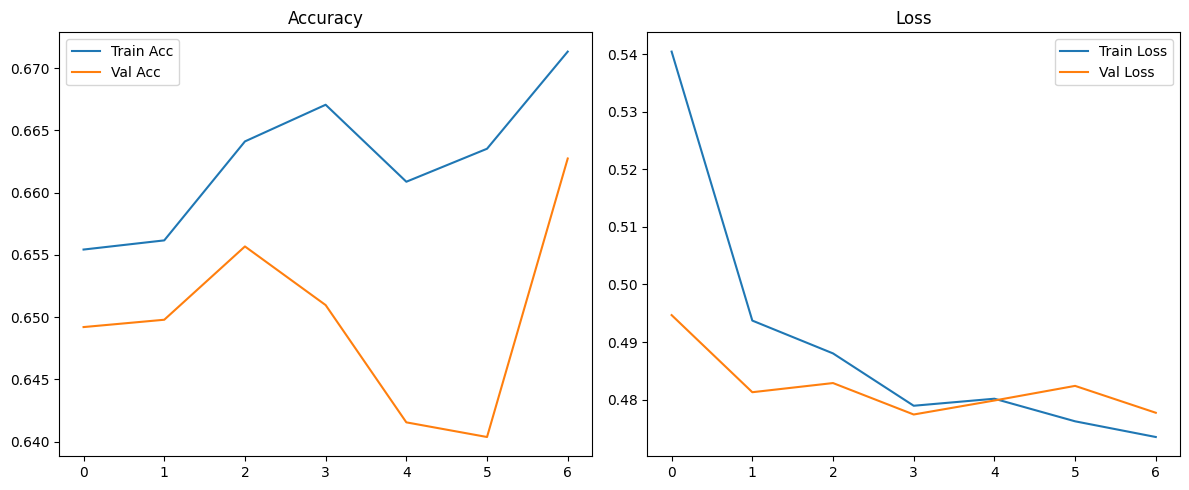

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step

🧾 Rapport de classification :

              precision    recall  f1-score   support

           0       0.84      0.56      0.67      1401
           1       0.48      0.80      0.60       723

    accuracy                           0.64      2124
   macro avg       0.66      0.68      0.64      2124
weighted avg       0.72      0.64      0.65      2124



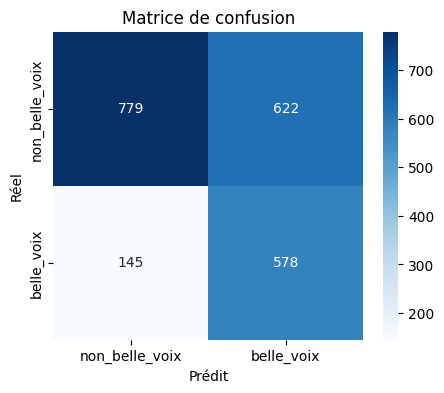

✅ Modèle sauvegardé : /content/drive/MyDrive/lstm_belle_voix_model.h5


In [ ]:
# 📦 Imports
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

# 🔧 Configuration
SAMPLE_RATE = 22050
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
DATA_PATH = "/content/drive/MyDrive"  # à adapter si besoin

# 🎵 Extraction MFCC
def extract_mfcc(file_path, max_len=SAMPLES_PER_TRACK):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        if len(audio) < max_len:
            audio = np.pad(audio, (0, max_len - len(audio)))
        else:
            audio = audio[:max_len]
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        return mfcc.T
    except Exception as e:
        print(f"❌ Erreur MFCC : {file_path} : {e}")
        return None

# 📂 Chargement des données
def load_mfcc_data():
    X, y = [], []
    labels_map = {"belle_voix": 1, "non_belle_voix": 0}
    for folder_name, label in labels_map.items():
        folder_path = os.path.join(DATA_PATH, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Dossier introuvable : {folder_path}")
            continue
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".wav"):
                path = os.path.join(folder_path, file_name)
                mfcc_data = extract_mfcc(path)
                if mfcc_data is not None:
                    X.append(mfcc_data)
                    y.append(label)
    return np.array(X, dtype=object), np.array(y)

# ✅ Chargement et padding
X_mfcc, y_mfcc = load_mfcc_data()
print(f"✅ Chargé : {len(X_mfcc)} fichiers")

max_length = max([x.shape[0] for x in X_mfcc])
X_mfcc_padded = pad_sequences(X_mfcc, maxlen=max_length, dtype='float32', padding='post')
X_mfcc_padded = X_mfcc_padded[..., np.newaxis]  # ajout canal

# ✂️ Split
X_train, X_test, y_train, y_test = train_test_split(
    X_mfcc_padded, y_mfcc, test_size=0.2, stratify=y_mfcc, random_state=42
)

# 🧠 Modèle LSTM
def create_lstm_model(input_shape):
    model = models.Sequential([
        layers.Masking(mask_value=0., input_shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 🚀 Entraînement
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 📈 Courbes
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Évaluation
y_pred = (lstm_model.predict(X_test) > 0.5).astype("int32")
print("\n🧾 Rapport de classification :\n")
print(classification_report(y_test, y_pred))

# 🔍 Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["non_belle_voix", "belle_voix"], yticklabels=["non_belle_voix", "belle_voix"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 💾 Sauvegarde
model_path = '/content/drive/MyDrive/lstm_belle_voix_model.h5'
lstm_model.save(model_path)
print(f"✅ Modèle sauvegardé : {model_path}")

# 🔮 Prédiction sur fichier .wav
def predict_voice(file_path):
    mfcc = extract_mfcc(file_path)
    if mfcc is None:
        print("❌ MFCC non valide")
        return
    mfcc_padded = pad_sequences([mfcc], maxlen=max_length, dtype='float32', padding='post')
    mfcc_padded = mfcc_padded[..., np.newaxis]
    proba = lstm_model.predict(mfcc_padded)[0][0]
    classe = "belle_voix" if proba > 0.5 else "non_belle_voix"
    print(f"🔍 Fichier : {os.path.basename(file_path)}")
    print(f"🔊 Classe prédite : {classe} (probabilité : {proba:.2f})")

# Exemple : prediction sur un fichier
# predict_voice("/content/drive/MyDrive/belle_voix/exemple.wav")
